# Black Friday Sales Prediction

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from scipy.stats import norm
from scipy.stats import probplot


In [4]:
# For Encoding
from sklearn.preprocessing import LabelEncoder

In [5]:
# For Feature Importance
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [6]:
# For Cross Validation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [7]:
# For Machine Learning Models
from sklearn import model_selection
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Importing the datasets

In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Data Exploration

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     233599 non-null  int64  
 1   Product_ID                  233599 non-null  object 
 2   Gender                      233599 non-null  object 
 3   Age                         233599 non-null  object 
 4   Occupation                  233599 non-null  int64  
 5   City_Category               233599 non-null  object 
 6   Stay_In_Current_City_Years  233599 non-null  object 
 7   Marital_Status              233599 non-null  int64  
 8   Product_Category_1          233599 non-null  int64  
 9   Product_Category_2          161255 non-null  float64
 10  Product_Category_3          71037 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 19.6+ MB


## Data Visualization

In [11]:
categorical = ['Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status','Product_Category_1','Product_Category_2','Product_Category_3']
train_numerical = train[['Purchase']]


### 1. Bar Charts for Categorical Variables 

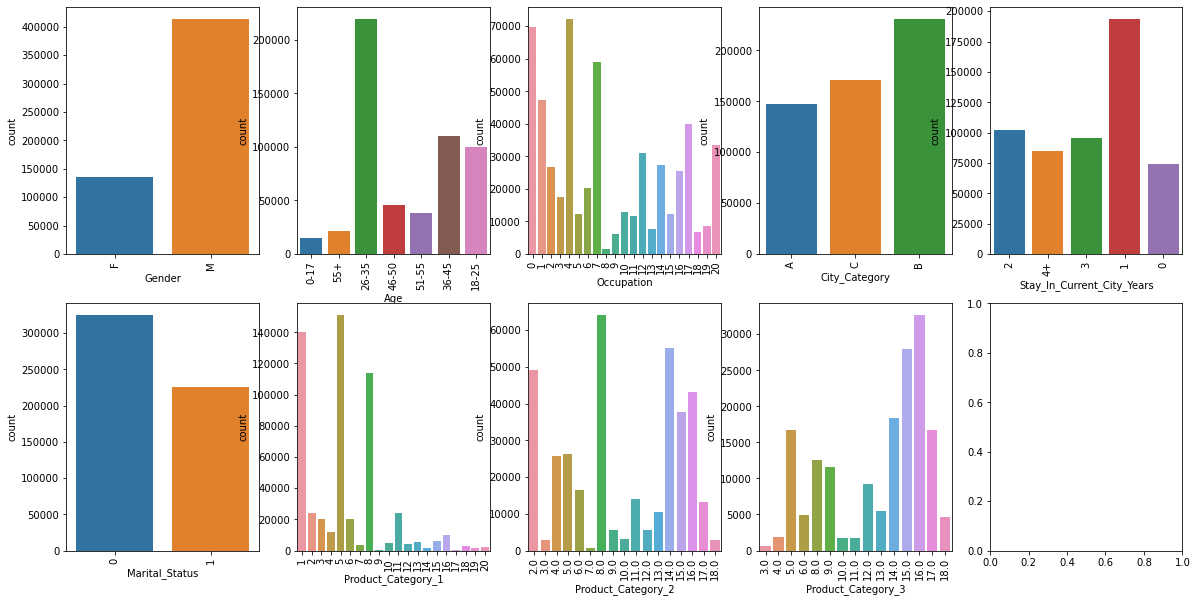

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

### 2. Histograms for Numerical Variables

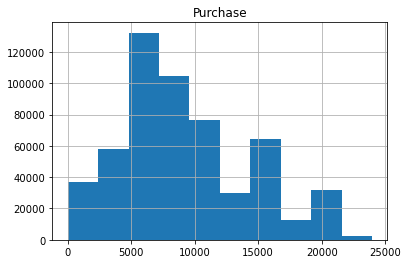

In [13]:
train_numerical.hist()
plt.show()

### 3. Box Plots To Check For Outliers

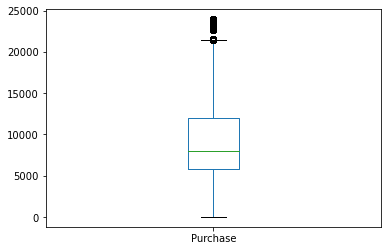

In [14]:
train_numerical.plot(kind='box')
plt.show()

## Checking Missing Values

In [15]:
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

'Product_Category_2' and 'Product_Category_3' columns in train dataset contain 173638 and 383247 missing values respectively.

In [16]:
test.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

'Product_Category_2' and 'Product_Category_3' columns in test dataset contain 72344 and 162562 missing values respectively.

### Checking for duplicate rows

In [17]:
# Checking for duplicate rows
train[train.duplicated(keep = 'last')]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase


In [18]:
test[test.duplicated(keep = 'last')]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3


No duplicated rows in both the train and test datasets

## Data Preprocessing

### Converting 'Product_ID' into integer dtype variable


In [19]:
train['Product_ID'] = train['Product_ID'].str[1:]
test['Product_ID'] = test['Product_ID'].str[1:]

train['Product_ID'] = train['Product_ID'].astype(np.int64)
test['Product_ID'] = test['Product_ID'].astype(np.int64)


## Missing Value Imputation

Missing values are present in the columns 'Product_Category_1' and 'Product_Category_2'. These missing values occur when a product is present only in 1 or 2 categories. 

In [20]:
train = train.fillna(0)
test = test.fillna(0)

In [21]:
train.describe()

,User_ID,Product_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000
mean,1.003029e+06,174744.814667,8.076707,0.409653,5.404270,6.735436,3.841941,9263.968713
std,1.727592e+03,102746.516956,6.522660,0.491770,3.936211,6.215492,6.250712,5023.065394
min,1.000001e+06,142.000000,0.000000,0.000000,1.000000,0.000000,0.000000,12.000000
25%,1.001516e+06,97142.000000,2.000000,0.000000,1.000000,0.000000,0.000000,5823.000000
50%,1.003077e+06,169742.000000,7.000000,0.000000,5.000000,5.000000,0.000000,8047.000000
75%,1.004478e+06,259142.000000,14.000000,1.000000,8.000000,14.000000,8.000000,12054.000000
max,1.006040e+06,375436.000000,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [22]:
test.describe()

,User_ID,Product_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
count,2.335990e+05,233599.000000,233599.000000,233599.000000,233599.000000,233599.000000,233599.000000
mean,1.003029e+06,173148.445661,8.085407,0.410070,5.276542,6.799237,3.852756
std,1.726505e+03,101682.144110,6.521146,0.491847,3.736380,6.217668,6.256634
min,1.000001e+06,142.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.001527e+06,96742.000000,2.000000,0.000000,1.000000,0.000000,0.000000
50%,1.003070e+06,165742.000000,7.000000,0.000000,5.000000,5.000000,0.000000
75%,1.004477e+06,256642.000000,14.000000,1.000000,8.000000,14.000000,8.000000
max,1.006040e+06,370642.000000,20.000000,1.000000,18.000000,18.000000,18.000000


In [23]:
# Removing values of 'Product_Category_1 in the train dataset that are not present in the test dataset
train = train[train['Product_Category_1'] <= 18]

## Feature Generation

In [24]:
# Creating additional features in the train dataset and mapping them into the test dataset
def transform_test(base_col, feat_col):
   
    #Create dictionary of feature values from train data
    di = pd.Series(train[feat_col].values, index=train[base_col].values).to_dict()
        
    return test[base_col].map(di).astype(float)

In [25]:
train['Product_Category_1_count'] = train.groupby('Product_Category_1')['Product_Category_1'].transform('count')
test['Product_Category_1_count'] = transform_test('Product_Category_1','Product_Category_1_count' )

train['Product_Category_2_count'] = train.groupby('Product_Category_2')['Product_Category_2'].transform('count')
test['Product_Category_2_count'] = transform_test('Product_Category_2','Product_Category_2_count' )

train['Product_Category_3_count'] = train.groupby('Product_Category_3')['Product_Category_3'].transform('count')
test['Product_Category_3_count'] = transform_test('Product_Category_3','Product_Category_3_count' )

In [26]:
train['UserID_Mean_Purchase'] = train.groupby('User_ID')['Purchase'].transform('mean')
test['UserID_Mean_Purchase'] = transform_test('User_ID', 'UserID_Mean_Purchase')

train['ProductID_Mean_Purchase'] = train.groupby('Product_ID')['Purchase'].transform('mean')
test['ProductID_Mean_Purchase'] = transform_test('Product_ID', 'ProductID_Mean_Purchase')

train['UserID_Median_Purchase'] = train.groupby('User_ID')['Purchase'].transform('median')
test['UserID_Median_Purchase'] = transform_test('User_ID', 'UserID_Median_Purchase')

train['ProductID_Median_Purchase'] = train.groupby('Product_ID')['Purchase'].transform('median')
test['ProductID_Median_Purchase'] = transform_test('Product_ID', 'ProductID_Median_Purchase')



In [27]:
train['UserID_Mean_Purchase'] = train.groupby('User_ID')['Purchase'].transform('mean')
test['UserID_Mean_Purchase'] = transform_test('User_ID', 'UserID_Mean_Purchase')

train['ProductID_Mean_Purchase'] = train.groupby('Product_ID')['Purchase'].transform('mean')
test['ProductID_Mean_Purchase'] = transform_test('Product_ID', 'ProductID_Mean_Purchase')

train['UserID_Median_Purchase'] = train.groupby('User_ID')['Purchase'].transform('median')
test['UserID_Median_Purchase'] = transform_test('User_ID', 'UserID_Median_Purchase')

train['ProductID_Median_Purchase'] = train.groupby('Product_ID')['Purchase'].transform('median')
test['ProductID_Median_Purchase'] = transform_test('Product_ID', 'ProductID_Median_Purchase')

## Encoding categorical variables

In [28]:
for col in ['Occupation','Marital_Status','Product_Category_1','Product_Category_2','Product_Category_3']:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

In [29]:
# Encoding column 'Stay_In_Current_City_Years' with label encoding since the variable contains values with an order. 
le = LabelEncoder()
train['Stay_In_Current_City_Years'] = le.fit_transform(train['Stay_In_Current_City_Years'])
test['Stay_In_Current_City_Years'] = le.fit_transform(test['Stay_In_Current_City_Years'])

Binary variables such as 'Gender' and 'Marital_Status' are encoded using onehot encoding. 

In [30]:
# Encoding binary columns with onehot encoding
train = pd.get_dummies(train,columns = ['Gender','Marital_Status'], drop_first=True)
test = pd.get_dummies(test,columns = ['Gender','Marital_Status'],drop_first=True)

Tree-based models and ensemble models cannot handle variables with high cardinality that are one-hot encoded. Label encoding cannot be used as it introduces ordinality among the values. Hence, the Variables 'Age', 'Occupation','City_Category','Product_Category_1','Product_Category_2' and 'Product_Category_3' are encoded using frequency encoding. 

In [31]:
## Frequency encoding 

# Creating a list of categorical columns to iterate over
cat_cols = ['Age','Occupation','City_Category','Product_Category_1','Product_Category_2','Product_Category_3']

def freq_encode(data):
    fq = data.groupby(col).size()/len(data)  
# mapping values to dataframe
    data.loc[:, "{}_freq_encoded".format(col)] = data[col].map(fq) 
# drop original column.
    data.drop([col], axis = 1,inplace = True)
    return data

# Creating a for loop to iterate through each column in the data
for col in cat_cols:
    freq_encode(train)
    freq_encode(test)

## Outlier Treatment

The values that are higher the 3rd quartile are outliers and therefore, removed from the dataset. 

In [32]:
q1 = np.percentile(train['Purchase'],25)
q3 = np.percentile(train['Purchase'],75)
iqr = q3-q1
upper = q3+1.5*iqr
lower = q1-1.5*iqr
lower, upper

(-3440.5, 21379.5)

In [33]:
train_iqr = train[(train['Purchase']<upper) & (train['Purchase']>lower)]
train_iqr.shape

(543210, 19)

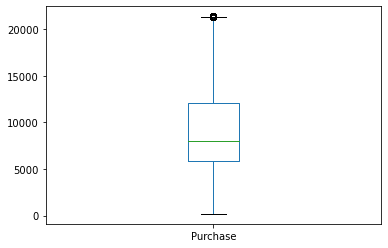

In [34]:
train_iqr['Purchase'].plot(kind='box')
plt.show()

## Splitting the Train dataset into X and y

In [35]:
X= train_iqr.drop(columns = ['Purchase'], axis=1)
y= train_iqr['Purchase']

## Feature Selection

### 1. Feature Selection with Anova Fscore

In [37]:
# Defining feature selection 
selector = SelectKBest(f_regression, k='all')

# Applying transformation to the training set
X_new = selector.fit_transform(X, y)  

# Getting names of the selected features
mask = selector.get_support()     

# Scores for selected features
print(selector.scores_)     

# Getting a list of selected features
new_features = X.columns[mask]
print(new_features)   

X = X[new_features]
test = test[new_features]


[9.98921529e+00 2.95529589e+03 1.69025785e+01 6.99089850e+02
 2.46109395e+04 6.10645857e+04 6.65299239e+04 1.30822838e+06
 5.63703120e+04 1.20563170e+06 2.00818122e+03 9.32471197e-01
 1.51592526e+00 2.96674387e+00 2.25097574e+01 6.99089850e+02
 2.46109395e+04 6.10645857e+04]
Index(['User_ID', 'Product_ID', 'Stay_In_Current_City_Years',
       'Product_Category_1_count', 'Product_Category_2_count',
       'Product_Category_3_count', 'UserID_Mean_Purchase',
       'ProductID_Mean_Purchase', 'UserID_Median_Purchase',
       'ProductID_Median_Purchase', 'Gender_M', 'Marital_Status_1',
       'Age_freq_encoded', 'Occupation_freq_encoded',
       'City_Category_freq_encoded', 'Product_Category_1_freq_encoded',
       'Product_Category_2_freq_encoded', 'Product_Category_3_freq_encoded'],
      dtype='object')


## Building the Machine Learning Models and Stratified K-Fold Cross Validation

In [38]:
# Implementing cross validation
def kfold_cv(X, y, algorithm, params,n_jobs=-1):
    kfold = KFold(n_splits=5, random_state=1, shuffle = True)
 
    for train_index , test_index in kfold.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = algorithm(**params) 
        model.fit(X_train,y_train, verbose = 400)
        pred = model.predict(X_test)

        score = mean_squared_error(y_test, pred,squared = False)
        r2 = r2_score(y_test, pred)
        print(f"RMSE: {score}")
        print(f"R-squared: {r2}")
    return model
    return mean(score)
    print(mean(score))

In [39]:
xgbr_params = {'eta':0.1,'max_depth':10,'min_child_weight': 7}
xgbr_model = kfold_cv(X, y, XGBRegressor, xgbr_params)

RMSE: 2440.8577528468277
R-squared: 0.7516195807654685
RMSE: 2439.5933553214786
R-squared: 0.75192021156923
RMSE: 2453.8750904335225
R-squared: 0.7479938970445711
RMSE: 2452.810012560442
R-squared: 0.7490448766999095
RMSE: 2443.1752262858513
R-squared: 0.750532740473522


In [40]:
lgbm_params = {'learning_rate': 0.15,'max_depth': 10,'num_leaves':70}
lgbm_model = kfold_cv(X, y, LGBMRegressor, lgbm_params)

RMSE: 2456.491204116848
R-squared: 0.7484276877280533
RMSE: 2454.5521999448047
R-squared: 0.7488685846879253
RMSE: 2467.1243533890492
R-squared: 0.7452652259534718
RMSE: 2466.6687208659846
R-squared: 0.7462010044264302
RMSE: 2456.605593953249
R-squared: 0.7477825113319676


In [41]:
catb_params = {'learning_rate': 0.12,'depth': 8}
catb_model = kfold_cv(X,y,CatBoostRegressor,catb_params)

0:	learn: 4490.2196253	total: 222ms	remaining: 3m 41s
400:	learn: 2407.6781222	total: 21.5s	remaining: 32.1s
800:	learn: 2344.9821197	total: 41.9s	remaining: 10.4s
999:	learn: 2319.5778715	total: 51.5s	remaining: 0us
RMSE: 2434.149546318176
R-squared: 0.7529829519474662
0:	learn: 4491.2196729	total: 83.3ms	remaining: 1m 23s
400:	learn: 2404.5229897	total: 20s	remaining: 29.9s
800:	learn: 2344.1893861	total: 38.8s	remaining: 9.65s
999:	learn: 2319.0704616	total: 48s	remaining: 0us
RMSE: 2432.524063936854
R-squared: 0.7533558667038204
0:	learn: 4492.7445444	total: 55ms	remaining: 55s
400:	learn: 2404.2128191	total: 19.2s	remaining: 28.7s
800:	learn: 2341.1291303	total: 38.1s	remaining: 9.47s
999:	learn: 2316.6097089	total: 48.3s	remaining: 0us
RMSE: 2445.311489941662
R-squared: 0.7497497434876093
0:	learn: 4489.2347176	total: 66.1ms	remaining: 1m 6s
400:	learn: 2404.6685111	total: 19.3s	remaining: 28.8s
800:	learn: 2342.9702699	total: 38.1s	remaining: 9.46s
999:	learn: 2317.4284966	total

## Predicting the Test Results

In [42]:
# As the XGBoost and CatBoost models are more accurate due to similar RMSE values, the values for 'Purchase' in test dataset are predicted using these models. Their averages are taken as the final predicted values. 
pred_xgbr = xgbr_model.predict(test)
pred_catb = catb_model.predict(test)
y_pred = (pred_xgbr + pred_catb)/2

## Adding Predicted Values to the Submission File

In [43]:
submission = pd.read_csv('sample_submission.csv')
submission['Purchase'] = pred_catb
submission.to_csv('sample_submission.csv', index=False)